In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [12]:
transform=transforms.Compose({
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
})

In [13]:
dataset_path="./data/flowers"
train_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"/train",transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"/test",transform=transform)
validate_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"/valid",transform=transform)

In [14]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)

### Dataset info

In [15]:
def dataset_info(loader,dataset_name="Dataset"):
    print(f"Dataset {dataset_name}")
    print(f"Total Samples : {len(loader.dataset)}")

    images, labels = next(iter(loader))
    print(f"Batch Size : {images.shape[0]}")
    print(f"Images shape: {images.shape}")
    print(f"Unique classes: {set(labels.numpy())}")
    print(f"Total classes: {len(set(labels.numpy()))}")
dataset_info(train_loader, "Training set")

Dataset Training set
Total Samples : 1275
Batch Size : 32
Images shape: torch.Size([32, 3, 224, 224])
Unique classes: {np.int64(0), np.int64(1)}
Total classes: 2


In [16]:
device=torch.device('cuda' if torch.cuda.is_available() else 'gpu')
criterion=nn.CrossEntropyLoss()
# optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [17]:
class AlexNet(nn.Module):
    def __init__(self,num_classes=2):
        super(AlexNet, self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,num_classes)
        )
    def forward(self,x):
        x=self.features(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x

## Model optimization and loss functions

In [18]:
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model=AlexNet(num_classes=2).to(device=device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [19]:
def evaluate():
    model.eval()
    correct,total=0.0,0.0
    with torch.no_grad():
        for images,lables in test_loader:
            images,lables = images.to(device),lables.to(device)
            outputs=model(images)
            _, predicted=outputs.max(1)
            total+=lables.size(0)
            correct+=predicted.eq(lables).sum().item()
    accurracy=100.*correct/total
    print(f"Accurracy Test: {accurracy:.2f}%")
    return accurracy

## Model Inferencing

In [20]:
def Predict(image_path):
    from PIL import Image
    image=Image.open(image_path)
    image=transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output=model(image)
        _,predicted=output.max(0)
    print(f"Predicted Class : {predicted.item()}")
    return predicted.item()

### Visualize of loss and accurracy

In [21]:
def plot_matrics(train_losses,test_accurracies):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses,label='Training losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(test_accurracies,label='Testing losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [23]:
## Train set

def train(num_epochs=10):
    train_losses, train_accuracies=[],[]
    for epoch in range(num_epochs):
        model.train()
        running_loss,correct, total=0.0,0,0
        for images, labels in train_loader:
            images, labels =images.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
        epoch_loss=running_loss/len(train_loader)
        epoch_acc=100.*correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}, loss: {epoch_loss:.4f}, Accurracy: {epoch_acc:2f}%")
    return train_losses,train_accuracies


In [28]:
### Run training, evalution and plot results
print('#'*50)
print('Training Started')
train_losses, train_accurracies=train(num_epochs=25)
print('Training completed')

##################################################
Training Started
Epoch 1, loss: 0.3146, Accurracy: 86.196078%
Epoch 2, loss: 0.3095, Accurracy: 86.196078%
Epoch 3, loss: 0.2781, Accurracy: 88.784314%
Epoch 4, loss: 0.2937, Accurracy: 87.450980%
Epoch 5, loss: 0.2555, Accurracy: 89.333333%
Epoch 6, loss: 0.2638, Accurracy: 88.392157%
Epoch 7, loss: 0.2363, Accurracy: 89.960784%
Epoch 8, loss: 0.2483, Accurracy: 90.117647%
Epoch 9, loss: 0.2302, Accurracy: 90.352941%
Epoch 10, loss: 0.2219, Accurracy: 91.607843%
Epoch 11, loss: 0.2041, Accurracy: 91.843137%
Epoch 12, loss: 0.2149, Accurracy: 91.843137%
Epoch 13, loss: 0.1871, Accurracy: 91.529412%
Epoch 14, loss: 0.2346, Accurracy: 89.960784%
Epoch 15, loss: 0.1817, Accurracy: 91.921569%
Epoch 16, loss: 0.1811, Accurracy: 92.549020%
Epoch 17, loss: 0.1807, Accurracy: 93.254902%
Epoch 18, loss: 0.1998, Accurracy: 91.764706%
Epoch 19, loss: 0.1927, Accurracy: 92.549020%
Epoch 20, loss: 0.1485, Accurracy: 94.352941%
Epoch 21, loss: 0.147

##################################################
Evaluation started
Accurracy Test: 86.26%
Evaluation ended
##################################################
Plotting matrices


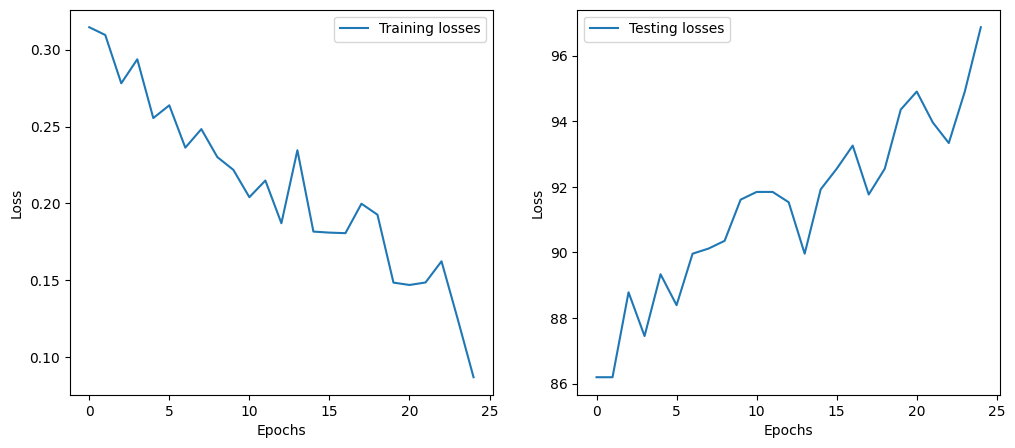

In [29]:
print('#'*50)
print('Evaluation started')
evaluate()
print('Evaluation ended')
print('#'*50)
print('Plotting matrices')
plot_matrics(train_losses, train_accurracies)

